In [79]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import joblib

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [80]:
def rel_errors(model, X_train, y_train, X_test, y_test):

    train_mae = (sum(abs(y_train - model.predict(X_train)))/len(y_train))/y_train.mean()
    train_mape = (sum(abs(y_train - model.predict(X_train))*100)/len(y_train))/y_train.mean()

    test_mae = (sum(abs(y_test - model.predict(X_test)))/len(y_test))/y_test.mean()
    test_mape = (sum(abs(y_test - model.predict(X_test))*100)/len(y_test))/y_test.mean()

    print(f"rel_train_mae: {train_mae}")
    print(f"rel_test_mae: {test_mae}")
    print(f"rel_train_mape: {train_mape}")
    print(f"rel_test_mape: {test_mape}")

In [81]:
file_path = '{}/nem-data/nemde_clean/df_clean_interconnectors.pkl'.format(os.environ['HOME'])
df = pd.read_pickle(file_path)
df.drop(columns="weekday_cos", inplace=True)

In [82]:
df.isna().any()

CO2E_EMISSIONS_FACTOR    False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
weekday_sin              False
month_sin                False
month_cos                False
lag1                     False
lag2                     False
lag3                     False
lag4                     False
lag5                     False
lag6                     False
lag7                     False
lag8                     False
lag9                     False
lag10                    False
lag11                    False
lag12                    False
horizon0                 False
demand                   False
demand_capacity          False
interconnector           False
dtype: bool

In [95]:
df.shape

(807149, 24)

In [83]:
df.head()

,CO2E_EMISSIONS_FACTOR,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,lag1,lag2,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2009-09-01 01:05:00,0.980592,0.500000,8.660254e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,0.871459,0.976360,...,0.97636,0.97636,0.975655,1.032780,0.976889,0.976360,0.980592,1540.46,0.561122,204.99
2009-09-01 01:10:00,1.154818,0.866025,5.000000e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,0.980592,0.871459,...,0.97636,0.97636,0.976360,0.975655,1.032780,0.976889,1.154818,1499.28,0.545420,171.40
2009-09-01 01:15:00,0.976360,1.000000,2.832769e-16,0.258819,0.965926,0.0,-1.0,-1.836970e-16,1.154818,0.980592,...,0.97636,0.97636,0.976360,0.976360,0.975655,1.032780,0.976360,1509.50,0.550675,181.68
2009-09-01 01:20:00,0.976360,0.866025,-5.000000e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,0.976360,1.154818,...,0.98698,0.97636,0.976360,0.976360,0.976360,0.975655,0.976360,1504.69,0.548709,176.25
2009-09-01 01:25:00,0.976360,0.500000,-8.660254e-01,0.258819,0.965926,0.0,-1.0,-1.836970e-16,0.976360,0.976360,...,0.98698,0.98698,0.976360,0.976360,0.976360,0.976360,0.976360,1493.48,0.544586,166.35


In [84]:
df_train_val = df[df.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set = df[df.index >= dt.datetime(2017,5,31,0,0,0)]

In [85]:
def train_test_ts(df, relative_train, maximal_lag):
    '''
    Time series (ts) split function creates a train/test set under consideration of potential overlap between the two due to lag processing
    X_train, y_train, X_test, y_test = ...
    df=must contain target column as "target"; all other columns must be used as features
    percentage_train=how much of the total dataset shall be used for training; must be added between 0 - 1
    maximal_lag=out of all lag feature engineering, enter the maximal lag number
    '''
    k = int(df.shape[0] * relative_train)
    data_train = df.iloc[:k,:]
    #to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
    data_test = df.iloc[k+maximal_lag:,:]
    
    assert data_train.index.max() < data_test.index.min()
    
    #returns in the sequence X_train, y_train, X_test, y_test
    return (data_train.drop(columns=["horizon0","CO2E_EMISSIONS_FACTOR"], axis=1), data_train["horizon0"],
            data_test.drop(columns=["horizon0","CO2E_EMISSIONS_FACTOR"], axis=1), data_test["horizon0"])

### __Training with no demand and interconncetors__

In [86]:
df1 = df.drop(columns=["demand", "demand_capacity", "interconnector"])

df_train_val1 = df1[df1.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set1 = df1[df1.index >= dt.datetime(2017,5,31,0,0,0)]

X_train1, y_train1, X_test1, y_test1 = train_test_ts(df_train_val1, 0.8, 12)

model1 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model1.fit(X_train1, y_train1)

rel_errors(model1,X_train1, y_train1, X_test1, y_test1)

/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:42:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.2801966701311946
rel_test_mae: 0.27023513688202067
rel_train_mape: 28.01966701317628
rel_test_mape: 27.023513688203767


### __Training with demand__

In [21]:
df3 = df.drop(columns="interconnector")

df_train_val3 = df3[df3.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set3 = df3[df3.index >= dt.datetime(2017,5,31,0,0,0)]

X_train3, y_train3, X_test3, y_test3 = train_test_ts(df_train_val3, 0.8, 12)

model3 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model3.fit(X_train3, y_train3)

rel_errors(model3, X_train3, y_train3, X_test3, y_test3)

[23:11:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.27998509837746993
rel_test_mae: 0.2686899964373279
rel_train_mape: 27.998509837801283
rel_test_mape: 26.86899964373413


### __Training with interconnectors__

In [22]:
df2 = df.drop(columns=["demand", "demand_capacity"])

df_train_val2 = df2[df2.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set2 = df2[df2.index >= dt.datetime(2017,5,31,0,0,0)]

X_train2, y_train2, X_test2, y_test2 = train_test_ts(df_train_val2, 0.8, 12)

model2 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model2.fit(X_train2, y_train2)

rel_errors(model2, X_train2, y_train2, X_test2, y_test2)

[23:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.2802140747862288
rel_test_mae: 0.2731677083206807
rel_train_mape: 28.02140747867672
rel_test_mape: 27.316770832070517


### __Training with demand and interconnectors__

In [23]:
X_train, y_train, X_test, y_test = train_test_ts(df_train_val, 0.8, 12)

In [24]:
print(X_train.columns)
print(X_test.columns)

Index(['minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'demand',
       'demand_capacity', 'interconnector'],
      dtype='object')
Index(['minute_sin', 'minute_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'month_sin', 'month_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'demand',
       'demand_capacity', 'interconnector'],
      dtype='object')


In [25]:
print(X_train.index.max())
print(X_test.index.min())

2016-03-10 08:10:00
2016-03-10 09:15:00


In [26]:
model = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model.fit(X_train, y_train)

rel_errors(model, X_train, y_train, X_test, y_test)

[23:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.27959603558873336
rel_test_mae: 0.2687075709892779
rel_train_mape: 27.959603558926503
rel_test_mape: 26.870757098929374


### __including year__

In [75]:
df5 = df
df5["year"] = df5.index.year
df5.year.nunique()
df5['year_sin'] = np.sin(2 * np.pi * df.loc[:,'year']/11.0)
df5['year_cos'] = np.cos(2 * np.pi * df.loc[:,'year']/11.0)

In [77]:
df5.drop(columns="year", inplace=True)

In [88]:
df_train_val5 = df5[df5.index < dt.datetime(2017,5,31,0,0,0)]
df_test_set5 = df5[df5.index >= dt.datetime(2017,5,31,0,0,0)]

X_train5, y_train5, X_test5, y_test5 = train_test_ts(df_train_val5, 0.8, 12)

model5 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model5.fit(X_train5, y_train5)

rel_errors(model5, X_train5, y_train5, X_test5, y_test5)

[23:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rel_train_mae: 0.2794969179392685
rel_test_mae: 0.2689107432427029
rel_train_mape: 27.94969179397616
rel_test_mape: 26.891074324271063


In [89]:
joblib.dump(model5, '{}/nem-data/trainings/model5.pkl'.format(os.environ['HOME']))

['/home/bastian/nem-data/trainings/model5.pkl']

In [99]:
model5.feature_importances_
df5.iloc[:,1:]

,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,lag1,lag2,lag3,...,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector,year_sin,year_cos
2009-09-01 01:05:00,0.500000,8.660254e-01,0.258819,0.965926,0.0,-1.000000,-1.836970e-16,0.871459,0.976360,0.986980,...,0.975655,1.032780,0.976889,0.976360,0.980592,1540.46,0.561122,204.99000,-0.755750,-0.654861
2009-09-01 01:10:00,0.866025,5.000000e-01,0.258819,0.965926,0.0,-1.000000,-1.836970e-16,0.980592,0.871459,0.976360,...,0.976360,0.975655,1.032780,0.976889,1.154818,1499.28,0.545420,171.40000,-0.755750,-0.654861
2009-09-01 01:15:00,1.000000,2.832769e-16,0.258819,0.965926,0.0,-1.000000,-1.836970e-16,1.154818,0.980592,0.871459,...,0.976360,0.976360,0.975655,1.032780,0.976360,1509.50,0.550675,181.68000,-0.755750,-0.654861
2009-09-01 01:20:00,0.866025,-5.000000e-01,0.258819,0.965926,0.0,-1.000000,-1.836970e-16,0.976360,1.154818,0.980592,...,0.976360,0.976360,0.976360,0.975655,0.976360,1504.69,0.548709,176.25000,-0.755750,-0.654861
2009-09-01 01:25:00,0.500000,-8.660254e-01,0.258819,0.965926,0.0,-1.000000,-1.836970e-16,0.976360,0.976360,1.154818,...,0.976360,0.976360,0.976360,0.976360,0.976360,1493.48,0.544586,166.35000,-0.755750,-0.654861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01 03:35:00,-0.500000,-8.660254e-01,0.707107,0.707107,0.0,-0.866025,-5.000000e-01,0.573436,0.000000,0.573436,...,0.459168,0.573436,0.573436,0.570054,0.573436,1248.97,0.409481,17.02276,-0.281733,-0.959493
2019-08-01 03:40:00,-0.866025,-5.000000e-01,0.707107,0.707107,0.0,-0.866025,-5.000000e-01,0.573436,0.573436,0.000000,...,0.000000,0.459168,0.573436,0.573436,0.573436,1243.33,0.407500,11.98062,-0.281733,-0.959493
2019-08-01 03:45:00,-1.000000,-1.836970e-16,0.707107,0.707107,0.0,-0.866025,-5.000000e-01,0.573436,0.573436,0.573436,...,0.456409,0.000000,0.459168,0.573436,0.573436,1261.41,0.413046,25.68808,-0.281733,-0.959493
2019-08-01 03:50:00,-0.866025,5.000000e-01,0.707107,0.707107,0.0,-0.866025,-5.000000e-01,0.573436,0.573436,0.573436,...,0.573436,0.456409,0.000000,0.459168,0.456409,1250.76,0.410810,24.34067,-0.281733,-0.959493


In [90]:
def plot_feature_importances(rf, cols, model_dir):
    importances = pd.DataFrame()
    importances.loc[:, 'importances'] = rf.feature_importances_
    importances.loc[:, 'features'] = cols
    importances.sort_values('importances', inplace=True)
    f, a = plt.subplots()
    importances.plot(ax=a, kind='bar', x='features', y='importances')
    plt.gcf().subplots_adjust(bottom=0.3)
    f.savefig(os.path.join(model_dir, 'importances.png'))

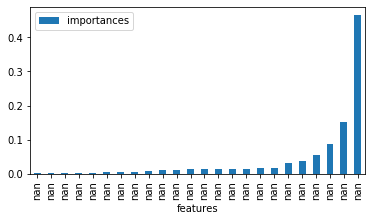

In [101]:
plot_feature_importances(model5, df5.iloc[:,1:],'{}/nem-data/trainings/'.format(os.environ['HOME']))

In [106]:
model5.feature_importances_

array([0.00129226, 0.004985  , 0.0062187 , 0.01340321, 0.01047543,
       0.0038012 , 0.00458755, 0.46585882, 0.15308   , 0.08707484,
       0.05517165, 0.03749905, 0.03065727, 0.01797603, 0.01189161,
       0.01505367, 0.01528706, 0.01420844, 0.01553354, 0.01729042,
       0.00350501, 0.00336656, 0.00855562, 0.00322707], dtype=float32)

### __Training after removal of cyclic__

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
df_resample = df.resample("5T").mean()

In [72]:
df_resample.isna().any()

CO2E_EMISSIONS_FACTOR    True
minute_sin               True
minute_cos               True
hour_sin                 True
hour_cos                 True
weekday_sin              True
month_sin                True
month_cos                True
lag1                     True
lag2                     True
lag3                     True
lag4                     True
lag5                     True
lag6                     True
lag7                     True
lag8                     True
lag9                     True
lag10                    True
lag11                    True
lag12                    True
horizon0                 True
demand                   True
demand_capacity          True
interconnector           True
dtype: bool

In [70]:
result = seasonal_decompose(df_resample.CO2E_EMISSIONS_FACTOR, model="additive")

ValueError: This function does not handle missing values

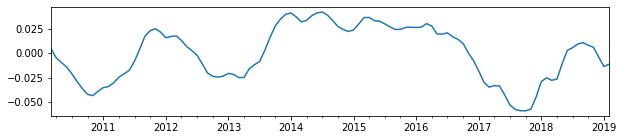

In [42]:
gdp_cycle, gdp_trend = hpfilter(result.trend.dropna(), lamb = 129600)
fig = gdp_cycle.plot(figsize=(10,2))

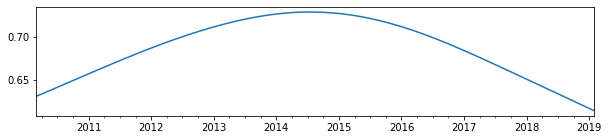

In [43]:
fig = gdp_trend.plot(figsize=(10,2))

In [60]:
result1 = result.trend.dropna()

In [51]:
df4 = df[(df.index >= result1.index.min()) & (df.index <= result1.index.max())]
df4.shape[0]*0.8

577456.8

In [55]:
df4.iloc[[577457],:]

,CO2E_EMISSIONS_FACTOR,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,month_sin,month_cos,lag1,lag2,...,lag7,lag8,lag9,lag10,lag11,lag12,horizon0,demand,demand_capacity,interconnector
2017-07-08 22:15:00,0.587113,1.0,2.832769e-16,-0.5,0.866025,0.781831,-0.5,-0.866025,0.196118,0.181661,...,0.573436,0.573436,0.573436,0.573436,0.573436,0.573436,0.587113,1472.38,0.592664,-100.0


In [58]:
df4.CO2E_EMISSIONS_FACTOR - result1.values

ValueError: operands could not be broadcast together with shapes (721821,) (108,) 

In [ ]:
df_train_val4 = df4[df4.index < dt.datetime(2017,7,1,0,0,0)]
df_test_set4 = df4[df4.index >= dt.datetime(2017,7,1,0,0,0)]

X_train4, y_train4, X_test4, y_test4 = train_test_ts(df_train_val4, 0.8, 12)

model4 = xgb.XGBRegressor(max_depth=5,
                         learning_rate=0.1,
                         num_estimators=100,
                         n_jobs=7,
                         reg_alpha=0.05,
                         reg_lambda=0,
                        )

model2.fit(X_train2, y_train2)

rel_errors(model2, X_train2, y_train2, X_test2, y_test2)